# Project proposal

---

Group name: John Anderson Torres Mosquera

---


## Introduction

The introduction section includes

-   an introduction to the subject matter you're investigating
-   the motivation for your research question (citing any relevant literature)
-   the general research question you wish to explore
-   your hypotheses regarding the research question of interest.

-------

## Inbound Logistics Forecasting Benchmark

### Introduction

The problem at hand refers to forecasting the inbound material volume (in tons) on monthly basis for the next 4 months for an international automotive company. 

The motivation behind that was the lack of synchronization between suppliers and freight forwarders systems, causing over- or under-capacity planning whenever a plant’s material demands change abruptly, leading to higher logistics transportation costs. 

I published a paper last year about this system, as a result of a research on inbound forecasting systems that I started in 2018. It can be found here [Forecasting System for Inbound Logistics Material Flows at an International Automotive Company](https://www.mdpi.com/2673-4591/39/1/75). Howerver this codebase was written in R using the forecasting package [forecast](https://cran.r-project.org/package=forecast) by Robert Hyndman and George Athanasopoulos in their book [Forecasting at Scale](https://otexts.com/fpp3/). It included algorithms like SARIMA, Exponential Smoothing, Multilayer Neural Networks, Prophet and Vector Autoregression. At that point in time the python packages for timeseries forecasting were not as good as R's. However, the python ecosystem for forecasting has grown a lot in the recent years. There are Python packages like [nitxla](https://nixtlaverse.nixtla.io/), [lightgbm](https://lightgbm.readthedocs.io/en/latest/Python-API.html), [catboost](https://catboost.ai/), as well as LLM forecasting models like [chronos](https://huggingface.co/amazon/chronos-t5-large) that offer many additional functionalities to leverage the use of new algorithms. 

In the M5 competition results [link](https://www.sciencedirect.com/science/article/pii/S0169207021001874) it was shown that boosted tree models can outperform traditional statistical and deep learning forecasting methods. This is something we will be exploring in this project. 

In addition, I would like to use the historical covid numbers from the [European Centre for Disease Prevention and Control](https://www.ecdc.europa.eu/en/covid-19/data) to evaluate the influence of this variable on the accuracy of the predictions. This is something that has not been explored in research.

### Research question

Which new methods can be used to improve the forecasting accuracy for the Inbound Logistics Volume of an International Automotive Company?

The idea is to create a forecasting system which is accurate and robust to adapt for outliers and unexpected events( e.g. COVID-19). To evaluate the forecast accuracy the `MAE (Mean Absolute Error)` and `SMAPE (Symmetric Mean Absolute Error)` will be used. This will allow us to care about the fact that in some months the transportation volume could have been 0. 

The test timeframes are: 
- Jan 2022 - Apr 2022
- May 2022 - Aug 2022
- Jul 2022 - Oct 2022

This means that models tested in each frame can only be trained with data prior to that frame to avoid data leakage. 

One of the main Business KPI's to track forecast accuracy will be how many timeseries are in a particular `SMAPE` range, for that we will use the following intervals: 

- 0% to 10%
- 10 to 20%
- 20 to 30%
- 30 to 40%
- greater than 40%


The business experts are particularly interested in having a forecating systems for which most of the timeseries have a `SMAPE` of less or equal than 20%.

### Hypothesis

There are new forecasting methods which can deliver better accuracy than traditional statistical methods.


## Data description

In this section, you will describe the data set you wish to explore. This includes

-   description of the observations in the data set,
-   description of how the data was originally collected (not how you found the data but how the original curator of the data collected it).

----------

There are two dataset, one containing the historical volume data, another one containing the production data. In total there are:

- 624  inbound logistics Provider-Plant connections
- 18  plants
- 38  Providers

The historical transport volume data contains data since 2014-01-01 until 2022-10-01.
The historical production data contains data since 2014-01-01 until 2023-12-01. All data until October 2022 is actual produced values, the rest are planning values.

The two input data sources for this project are:

- **Inbound_Volume_Data.csv** contains the historical transported material volume since January 2014 until October 2022 on monthly basis. This data comes from the Logistics Parts Mangement System. 
    - **Timestamp**: Monthly data of the format YYYY/MM.
    - **Provider**: Logistics Service Provider.
    - **Plant**: Assembly Plant. 
    - **Actual Vol [Kg]**: Actual transported volume from Provider to Plant in kg. 
    - **Expected Vol [Kg]**: Expected transported volume from Provider to Plant in kg. $^1$
- **production_data.csv** contains the historical production levels of all the european plants in number of vehicles per month from January 2014 until October 2022. Data after October 2022 refers to planned production values. 
    - **Timestamp**:  Monthly data of the format YYYY/MM.
    - **Plant_X**: Column containing the production level for Plant X.

$^1$ *Expected in this context means the volume value which the internal ERP system would calculate. That means, given the number of units in the call-off order and using the weights of the parts, the total expected weight of a delivery can be calculated. However, as mentioned before, due to the sync issue, the delivered volume and expected volume would differ.*

Additionally, I will explore the Covid 19 cases data: 

- **Covid-19_cases_age_specific.csv**: This data file contains information on the 14-day notification rate of newly reported COVID-19 cases per 100 000 population by age group, week and country. Each row contains the corresponding data for a certain week and country. The file is updated weekly. [source](https://www.ecdc.europa.eu/en/publications-data/covid-19-data-14-day-age-notification-rate-new-cases). The Covid data ranges from 2020-01-06 until 2023-11-20.
    - **country**: Country name
    - **country_code**: cuontry code
    - **year_week**: YYYY-WW data
    - **age_group**: age group
    - **new_cases**: new covid cases
    - **population**: population 
    - **rate_14_day_per_100k**: covid rate per 100.000 inhabitants
    - **source**: Covid source type

The **Inbound_Volume_Data** and **production_data** were obtained from the ERP System of the company and were annonymized for research purposes. The Covid **Covid-19_cases_age_specific.csv** data is available on the website of the European Centre for Disease Prevention and Control.


## Analysis approach

In this section, you will provide a brief overview of your analysis approach. This includes:

-   Description of the response variable.
-   Visualization and summary statistics for the response variable.
-   List of variables that will be considered as predictors
-   Your model type (what kind of model(s) will you use ... e.g. linear regression)

----

### Response Variable 

The response variable is the number of monthly transported Kilograms of material volume from any Provider X to any Plant Y. This is available in the column `Actual Vol [Kg]`.

### Analysis Inbound Volume Data and Response Variable

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import re


In [2]:
df_vol = pd.read_csv("../data/raw/inbound_volume_data.csv", index_col=0)
df_vol["Year"] = df_vol["Timestamp"].apply(lambda x: x.split("/")[0]).astype(int)
df_vol["Month"] = df_vol["Timestamp"].apply(lambda x: x.split("/")[1]).astype(int)
df_vol["Timestamp"] = df_vol[["Year", "Month"]].apply(
    lambda x: datetime(x["Year"], x["Month"], 1), axis=1
)
# Create Timeseries Key
df_vol["ts_key"] = df_vol[["Provider", "Plant"]].apply(
    lambda x: x["Provider"] + "-" + x["Plant"], axis=1
)

In [3]:
df_vol.head()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg],Year,Month,ts_key
0,2015-07-01,Provider_1,Plant_1,19096,20298,2015,7,Provider_1-Plant_1
1,2015-08-01,Provider_1,Plant_1,187139,189973,2015,8,Provider_1-Plant_1
2,2015-09-01,Provider_1,Plant_1,181149,187798,2015,9,Provider_1-Plant_1
3,2015-10-01,Provider_1,Plant_1,202677,202327,2015,10,Provider_1-Plant_1
4,2015-11-01,Provider_1,Plant_1,272902,271765,2015,11,Provider_1-Plant_1


In [4]:
df_vol.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47058 entries, 0 to 60518
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Timestamp          47058 non-null  datetime64[ns]
 1   Provider           47058 non-null  object        
 2   Plant              47058 non-null  object        
 3   Actual Vol [Kg]    47055 non-null  object        
 4   Expected Vol [Kg]  46951 non-null  object        
 5   Year               47058 non-null  int64         
 6   Month              47058 non-null  int64         
 7   ts_key             47058 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 3.2+ MB


In [5]:
print("The historical transport volume data contains data since", df_vol['Timestamp'].min(), " until ", df_vol['Timestamp'].max())
print("in Total it contains data for", df_vol['ts_key'].nunique(), " inbound logistics Provider-Plant connections")
print("in Total it contains data for", df_vol['Plant'].nunique(), " plants")
print("in Total it contains data for", df_vol['Provider'].nunique(), " Providers")
print("in Total it contains ", df_vol.shape[0], " rows.")
print("in Total it contains ", df_vol.shape[1], " columns.")

The historical transport volume data contains data since 2014-01-01 00:00:00  until  2022-10-01 00:00:00
in Total it contains data for 624  inbound logistics Provider-Plant connections
in Total it contains data for 18  plants
in Total it contains data for 38  Providers
in Total it contains  47058  rows.
in Total it contains  8  columns.


### Data Transformations

In order to visualize the data. First we need to transform the columns `Actual Vol [Kg]` and `Expected Vol [Kg]`, which are in object type to float type.

In [6]:
df_vol["Actual Vol [Kg]"] = (
    df_vol["Actual Vol [Kg]"].str.replace(".", "").astype("float")
)
df_vol["Expected Vol [Kg]"] = df_vol["Expected Vol [Kg]"].str.replace(".", "")
df_vol["Expected Vol [Kg]"] = (
    df_vol["Expected Vol [Kg]"].str.replace(",", ".").astype("float")
)

# We can transform the units to Tons for ease of manipulation and plotting
df_vol["Actual Vol [Tons]"] = np.round(df_vol["Actual Vol [Kg]"] / 1000, 3)
df_vol["Expected Vol [Tons]"] = np.round(df_vol["Expected Vol [Kg]"] / 1000, 3)

In [7]:
df_vol.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47058 entries, 0 to 60518
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Timestamp            47058 non-null  datetime64[ns]
 1   Provider             47058 non-null  object        
 2   Plant                47058 non-null  object        
 3   Actual Vol [Kg]      47055 non-null  float64       
 4   Expected Vol [Kg]    46951 non-null  float64       
 5   Year                 47058 non-null  int64         
 6   Month                47058 non-null  int64         
 7   ts_key               47058 non-null  object        
 8   Actual Vol [Tons]    47055 non-null  float64       
 9   Expected Vol [Tons]  46951 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 3.9+ MB


To visualise the time series, we can plot a line graph over time for the Actual and Expected Vol columns. 

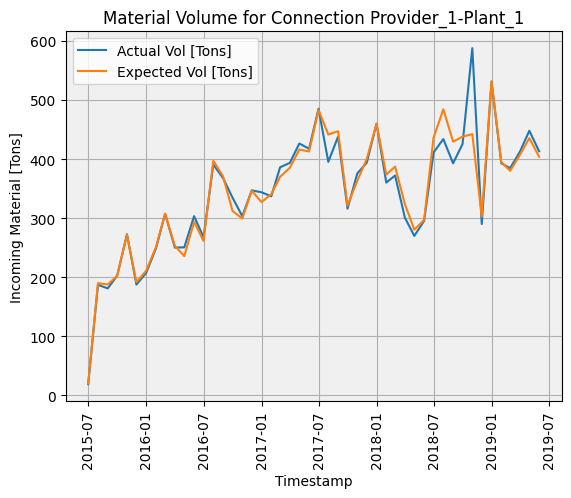

<Figure size 1200x500 with 0 Axes>

In [8]:
ts_key = "Provider_1-Plant_1"
x_axis = "Timestamp"
y1_axis = "Actual Vol [Tons]"
y2_axis = "Expected Vol [Tons]"
_df = df_vol.query(f" ts_key == '{ts_key}'")
x = _df[x_axis]
y1 = _df[y1_axis]
y2 = _df[y2_axis]


fig, ax = plt.subplots()

plt.rc("text", usetex=False)
plt.figure(figsize=(12, 5))

ax.plot(x, y1, label=y1_axis)
ax.plot(x, y2, label=y2_axis)
ax.grid(True)
ax.set_facecolor("#f0f0f0")
ax.set_xlabel(x_axis)
ax.tick_params(axis="x", rotation=90)
ax.set_ylabel("Incoming Material [Tons]")
ax.set_title(f"Material Volume for Connection {ts_key}")
ax.legend()

plt.show()

Here we can see that the `Actual Volume` and the `Expected Volume` are close to each other, indicating that they are highly correlated. We can check this by calculating the trend line of the two variables and plotting the actual vs expected volume in a scatter plot. The values of $R^2$ and *Correlation Coefficient* give us a sense of how strongly these two variables are correlated. 

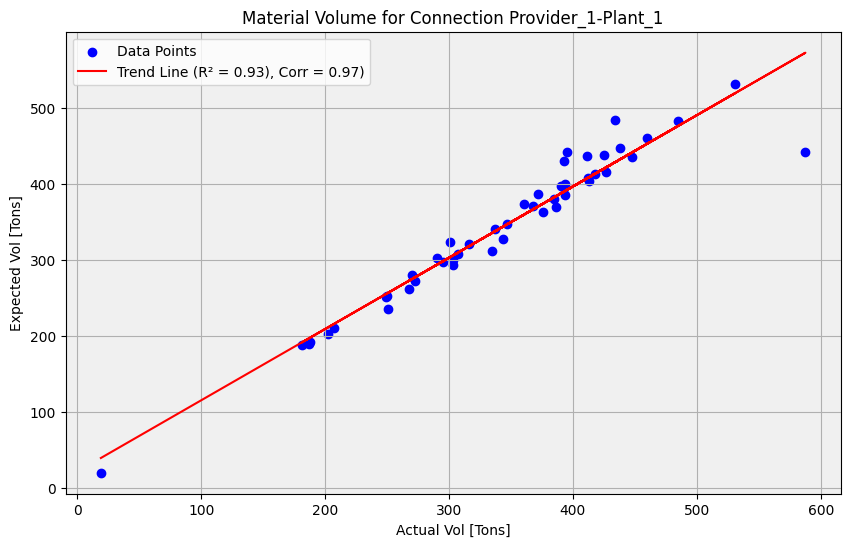

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

ts_key = "Provider_1-Plant_1"
y1_axis = "Actual Vol [Tons]"
y2_axis = "Expected Vol [Tons]"
_df = df_vol.query(f"ts_key == '{ts_key}'")
y1 = _df[y1_axis].values.reshape(-1, 1)
y2 = _df[y2_axis].values.reshape(-1, 1)

# Fit linear regression model
model = LinearRegression()
model.fit(y1, y2)
y2_pred = model.predict(y1)
r2 = r2_score(y2, y1)

corr_coeff = np.corrcoef(y1.flatten(), y2.flatten())[0, 1] 

fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot
ax.scatter(y1, y2, label="Data Points", color="blue")

# Plot trend line
ax.plot(y1, y2_pred, color="red", label=f"Trend Line (R² = {r2:.2f}), Corr = {corr_coeff:.2f})")

ax.grid(True)
ax.set_facecolor("#f0f0f0")
ax.set_xlabel(y1_axis)
ax.set_ylabel(y2_axis)
ax.set_title(f"Material Volume for Connection {ts_key}")
ax.legend()

plt.show()

For the Provider1-Plant1 connection, the correlation coefficient exceeds 0.5, indicating a strong positive correlation between the variables. However, it’s important to note that correlation does not imply causation. Since this analysis is based on observational data, we cannot infer any causal relationship; the data merely reflects associations without controlled experimentation as explained by Çetinkaya-Rundel and Hardin [Introduction to modern statistics](https://openintro-ims.netlify.app/).

We can now analyze the distibution of the Correlation Coefficients across all time series, to verify if this positive correlation is observed in all timeseries connections.

In [10]:
correlations = []
for ts_key in df_vol["ts_key"].unique():

    # Expected Volume might not be available for all past months
    _df = df_vol.query(f" ts_key == '{ts_key}'").dropna()

    # Only if there are at least more than 8 expected VOlume data points, then 
    # calculate the corr coefficient
    if _df.shape[0] > 8:
        x = _df[x_axis]
        y1 = _df[y1_axis]
        y2 = _df[y2_axis]
        corr = np.corrcoef(y1, y2)[0, 1]
        correlations.append(corr)

    del _df

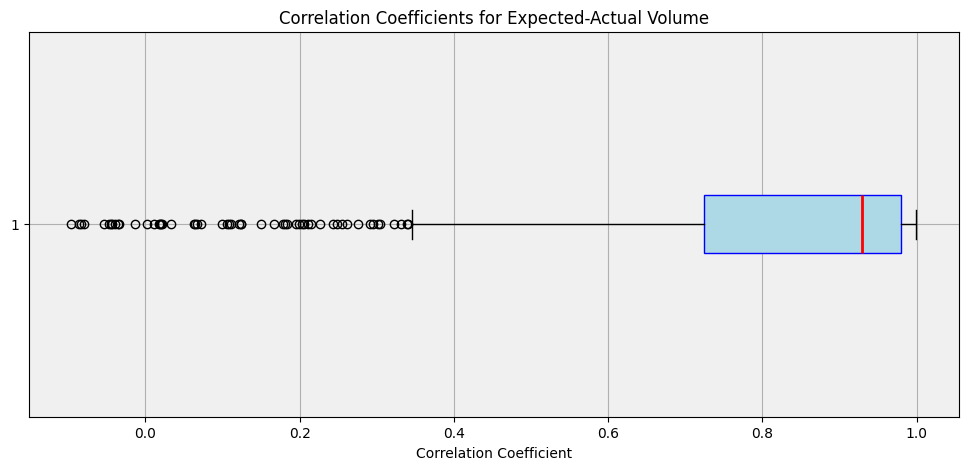

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))

# Box plot with custom appearance
ax.boxplot(correlations, vert=False, patch_artist=True, 
           boxprops=dict(facecolor="lightblue", color="blue"),
           medianprops=dict(color="red", linewidth=2))

ax.set_facecolor("#f0f0f0")
ax.set_xlabel("Correlation Coefficient")
ax.set_title("Correlation Coefficients for Expected-Actual Volume")
ax.grid(True)

plt.show()

In [12]:
_df = pd.DataFrame({'correlation_Expected_Actual':correlations})
_df.describe()

,correlation_Expected_Actual
count,565.000000
mean,0.792467
std,0.275825
min,-0.096765
25%,0.724799
50%,0.929280
75%,0.979473
max,0.999686


We calculated the correlation coefficients for 565 time series. The box plot reveals that the median correlation between Expected and Actual Volume is 0.92, with the 25th percentile at 0.72 and the 75th percentile at 0.97. This indicates that most time series exhibit a strong positive correlation. However, a few outliers show correlation coefficients below 0.3, suggesting weaker relationships for those specific cases. Overall, the data demonstrates that the majority of time series have moderate to strong positive correlations between the two variables.

To visualise all the time series, we can create a PDF report that allows us to go through them in a more visual way. 

In [13]:
# We can use the Matplotlib object PdfPages, to create a context, 
# in which each PDF page is generated and then appended to the whole document
pdf_path = "../reports/Inbound_Volume_Charts.pdf"
with PdfPages(pdf_path) as pdf:
    # ts_key = 'Provider_1-Plant_1'
    x_axis = "Timestamp"
    y1_axis = "Actual Vol [Tons]"
    y2_axis = "Expected Vol [Tons]"

    
    for ts_key in df_vol["ts_key"].unique():
        _df = df_vol.query(f" ts_key == '{ts_key}'")
        x = _df[x_axis]
        y1 = _df[y1_axis]
        y2 = _df[y2_axis]

        plt.ioff()

        # Activate autolayout so
        # that the whole plot fits into one page
        plt.rcParams["figure.autolayout"] = True

        fig, ax = plt.subplots()

        plt.rc("text", usetex=False)
        plt.figure(figsize=(12, 5))

        ax.plot(x, y1, label=y1_axis)
        ax.plot(x, y2, label=y2_axis)
        ax.grid(True)
        ax.set_facecolor("#f0f0f0")
        ax.set_xlabel(x_axis)
        ax.tick_params(axis="x", rotation=90)
        ax.set_ylabel("Incoming Material [Tons]")
        ax.set_title(ts_key)
        ax.legend()

        # saves the current figure into a pdf page
        pdf.savefig(fig)
        plt.close(fig)

        del _df
        del fig, ax

    # Set File Metadata infos
    d = pdf.infodict()
    d["Title"] = "Timeseries Tons"
    d["Author"] = "John Torres"
    d["CreationDate"] = datetime.today()

# Clear buffer
plt.clf()

/var/folders/c4/7xlj3rws5j14gj8d_xbctn4r0000gn/T/ipykernel_77877/3503897610.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 5))
/var/folders/c4/7xlj3rws5j14gj8d_xbctn4r0000gn/T/ipykernel_77877/3503897610.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


In the PDF *../reports/Inbound_Volume_Charts.pdf* we can observe that the `Actual Volume` and the `Expected Volume` can also deviate from each other largely. Additionally, Expected Volume is not available in the future, that is, we can only calculate feature from past values. 

#### Reponse Variable Description

In [14]:
desc = df_vol.describe()
desc

,Timestamp,Actual Vol [Kg],Expected Vol [Kg],Year,Month,Actual Vol [Tons],Expected Vol [Tons]
count,47058,4.705500e+04,4.695100e+04,47058.000000,47058.000000,47055.000000,46951.000000
mean,2018-05-12 19:43:06.510263552,4.446285e+05,8.292719e+05,2017.912172,6.412002,444.628452,829.271898
min,2014-01-01 00:00:00,1.000000e+00,0.000000e+00,2014.000000,1.000000,0.001000,0.000000
25%,2016-05-01 00:00:00,7.908550e+04,6.820250e+04,2016.000000,3.000000,79.085500,68.202500
50%,2018-06-01 00:00:00,2.480090e+05,2.206440e+05,2018.000000,6.000000,248.009000,220.644000
75%,2020-06-01 00:00:00,5.767820e+05,5.253174e+05,2020.000000,9.000000,576.782000,525.317500
max,2022-10-01 00:00:00,5.880148e+07,5.165009e+08,2022.000000,12.000000,58801.478000,516500.852000
std,NaN,7.162504e+05,9.156459e+06,2.430827,3.421207,716.250404,9156.458726


In [15]:
print("The mean of the material volume in tons among all connections is ", 
      np.round(desc['Actual Vol [Kg]']['mean'] /1000, 2))
print("The standard deviation of the material volume in tons among all connections is ", 
      np.round(desc['Actual Vol [Kg]']['std'] /1000, 2))
print("The max value of the material volume in tons among all connections is ", 
      np.round(desc['Actual Vol [Kg]']['max'] /1000, 2))
print("The min value of the material volume in tons among all connections is ", 
      np.round(desc['Actual Vol [Kg]']['min'] /1000, 2))

The mean of the material volume in tons among all connections is  444.63
The standard deviation of the material volume in tons among all connections is  716.25
The max value of the material volume in tons among all connections is  58801.48
The min value of the material volume in tons among all connections is  0.0


### Predictor Variables

In Timeseries forecasting it is common to carry out feature engineering using the response variable. For time dependent variables the common approach is to calculate lagged values as well as rolling statistics, e.g., rolling mean and rolling standard deviation. As for example explained by Manu Joseph in the chapter [Feature Engineering for Timeseries](https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/notebooks/Chapter06/01-Feature%20Engineering.ipynb) in the book [Modern Timeseries Forecasting with Python](https://www.oreilly.com/library/view/modern-time-series/9781835883181/).

For the **historical transport volume** data the predictor variable would be:

- Provider 
- Plant
- Expected Vol (Lagged Values, Rolling Mean, Rolling Std)
- Acutual Vol ( Lagged Values, Rolling Mean, Rolling Std)
- Year
- Month

For the **Covid Data Set** the reponse variables would be. After pivoting and transforming the data in order to match the timestamps values, I would use the following columns as predictors:

- monthly_rate_14_day_per_100k_per_country

Regarding the **Production Planning Data** it would be used as a smoothing factor to transform the response variable into the so called `Vol/Prod Ratio`. Because the production data and the inbound volume have a natural correlation. We can use this relationship to create a new target variable that will compensate for variations in the inbound volume. This new variable will be called `Vol/Prod Ratio`. 

This approach is possible since the production planning data is always available on monthly basis for the next 12 months in the future. So if we use `Vol/Prod Ratio` instead of `Actual Vol [Kg]` to train the model, we can then easly multiply the forecast values of `Vol/Prod Ratio` with the Production Planning values to get the forecast of `Actual Vol [Kg]`. 

### Production Data

In [16]:
df_prod = pd.read_csv("../data/raw/production_data.csv", index_col=0)
df_prod.head()

,Timestamp,Plant_6,Plant_9,Plant_13,Plant_15,Plant_17,Plant_19,Plant_21,Plant_11,Plant_4,Plant_12,Plant_20,Plant_14,Plant_22,Plant_1,Plant_3,Plant_5,Plant_18,Plant_10
0,2014/01,11848,54138,33839,19438,6770,29098,45147,8578,326919,11668,93855,68067,13127,26363,26363,5799,13749,3633
1,2014/02,13528,53063,36690,24252,6943,26975,42656,9739,334540,11275,92865,66012,18565,29822,29822,7978,12880,2880
2,2014/03,12753,50551,38211,24978,7695,28991,46226,10619,356075,12306,99860,71251,19505,28915,28915,8149,13348,4165
3,2014/04,12681,52528,36979,23872,7436,27409,47929,10379,351736,11790,95409,66233,23983,29441,29441,5020,15650,4457
4,2014/05,13272,50855,31164,24145,7415,27959,47255,12155,332888,10407,97371,69890,21139,28110,28110,7087,15940,4035


In [17]:
# There was no production in April 2020 due to the Covid lockdown
df_prod[df_prod['Timestamp']=="2020/04"]

,Timestamp,Plant_6,Plant_9,Plant_13,Plant_15,Plant_17,Plant_19,Plant_21,Plant_11,Plant_4,Plant_12,Plant_20,Plant_14,Plant_22,Plant_1,Plant_3,Plant_5,Plant_18,Plant_10
75,2020/04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
df_prod.describe()

,Plant_6,Plant_9,Plant_13,Plant_15,Plant_17,Plant_19,Plant_21,Plant_11,Plant_4,Plant_12,Plant_20,Plant_14,Plant_22,Plant_1,Plant_3,Plant_5,Plant_18,Plant_10
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.00000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,13486.116667,41007.675000,24771.058333,22840.625000,7454.408333,28224.400000,42591.175000,14639.016667,308748.908333,7596.100000,88380.708333,83607.033333,67994.27500,68041.225000,68041.225000,11089.691667,11813.000000,4428.658333
std,2661.744876,11119.648605,6856.099049,6229.474383,1541.047944,7218.555478,8472.606887,3303.749060,64233.309356,3709.346588,33069.851139,19596.796614,29526.32378,15112.725171,15112.725171,3732.863437,3669.537809,1312.024989
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11801.250000,33925.250000,18984.500000,18685.250000,6731.750000,24553.500000,38480.250000,13044.750000,282283.000000,4696.750000,61097.500000,72464.750000,39057.25000,62559.750000,62559.750000,8344.750000,9311.000000,3597.250000
50%,14181.500000,40437.500000,25675.500000,23967.000000,7801.000000,29025.500000,44473.500000,15307.500000,320305.000000,7987.500000,91953.000000,84206.000000,78820.50000,70230.500000,70230.500000,11745.000000,12699.500000,4820.000000
75%,15411.000000,49781.000000,30391.750000,27783.250000,8540.000000,33766.500000,48417.500000,16917.000000,353522.000000,10856.000000,113225.750000,98304.250000,90962.75000,78281.500000,78281.500000,14083.750000,14570.000000,5334.750000
max,18293.000000,65813.000000,38211.000000,33676.000000,9559.000000,41107.000000,57381.000000,18742.000000,409207.000000,13145.000000,153941.000000,121995.000000,113411.00000,90747.000000,90747.000000,16808.000000,17581.000000,7446.000000


The line above describes some statistics for the different plants. We can see that the min volume production is 0. Corresponding to the month of April 2020. The max production corresponds to the Plant_4 with a value of 409.207.

In [19]:
print("In total it contains data for", len(np.unique(df_prod.describe().columns)), " plants. The same number as in the historical volume data")
print("In total it contains data for", len(np.unique(df_prod.describe().columns)), " plants. The same number as in the historical volume data")

In total it contains data for 18  plants. The same number as in the historical volume data
In total it contains data for 18  plants. The same number as in the historical volume data


In [20]:
# Convert the Timestamp to a Datetime Object
df_prod["Year"] = df_prod["Timestamp"].apply(lambda x: x.split("/")[0]).astype(int)
df_prod["Month"] = df_prod["Timestamp"].apply(lambda x: x.split("/")[1]).astype(int)
df_prod["Timestamp"] = df_prod[["Year", "Month"]].apply(
    lambda x: datetime(x["Year"], x["Month"], 1), axis=1
)

# Unpivot columns to rows
df_prod = pd.melt(
    df_prod.drop(columns=["Month", "Year"]),
    id_vars=["Timestamp"],
    var_name="Plant",
    value_name="Production",
)

In [21]:
print("The historical production data contains data since", df_prod['Timestamp'].min(), " until ", df_prod['Timestamp'].max())
print("in Total it contains ", df_prod.shape[0], " rows.")
print("in Total it contains ", df_prod.shape[1], " columns.")

The historical production data contains data since 2014-01-01 00:00:00  until  2023-12-01 00:00:00
in Total it contains  2160  rows.
in Total it contains  3  columns.


### Covid Dataset 

In [22]:
df_covid = pd.read_csv("../data/raw/Covid-19_cases_age_specific.csv")

In [23]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35496 entries, 0 to 35495
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               35496 non-null  object 
 1   country_code          35496 non-null  object 
 2   year_week             35496 non-null  object 
 3   age_group             35496 non-null  object 
 4   new_cases             33018 non-null  float64
 5   population            35496 non-null  int64  
 6   rate_14_day_per_100k  32744 non-null  float64
 7   source                35496 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 2.2+ MB


In [24]:
df_covid.head()

,country,country_code,year_week,age_group,new_cases,population,rate_14_day_per_100k,source
0,Austria,AT,2020-01,<15yr,NaN,1291589,NaN,TESSy COVID-19
1,Austria,AT,2020-02,<15yr,NaN,1291589,NaN,TESSy COVID-19
2,Austria,AT,2020-03,<15yr,NaN,1291589,NaN,TESSy COVID-19
3,Austria,AT,2020-04,<15yr,NaN,1291589,NaN,TESSy COVID-19
4,Austria,AT,2020-05,<15yr,NaN,1291589,NaN,TESSy COVID-19


In [25]:
# Convert the Timestamp to a Datetime Object
df_covid['timestamp'] = pd.to_datetime(df_covid['year_week'] + '-1', format='%Y-%U-%w')

In [26]:
print("The Covid data ranges from", df_covid['timestamp'].min(), " until ", df_covid['timestamp'].max())
print("The file contains data for ", df_covid['country'].nunique(), " countries.")
print("The file contains data for ", df_covid['age_group'].nunique(), " age groups ", df_covid['age_group'].unique())
print("in Total it contains ", df_covid.shape[0], " rows.")
print("in Total it contains ", df_covid.shape[1], " columns.")

The Covid data ranges from 2020-01-06 00:00:00  until  2023-11-20 00:00:00
The file contains data for  29  countries.
The file contains data for  6  age groups  ['<15yr' '15-24yr' '25-49yr' '50-64yr' '65-79yr' '80+yr']
in Total it contains  35496  rows.
in Total it contains  9  columns.


In [27]:
df_covid.describe()

,new_cases,population,rate_14_day_per_100k,timestamp
count,33018.000000,3.549600e+04,32744.000000,35496
mean,5622.251469,2.561706e+06,430.245721,2021-12-11 07:38:49.411764736
min,0.000000,1.710000e+03,0.000000,2020-01-06 00:00:00
25%,56.000000,2.684660e+05,21.847788,2020-12-26 06:00:00
50%,399.000000,9.413035e+05,119.704047,2021-12-09 12:00:00
75%,2336.000000,2.672346e+06,422.658918,2022-11-29 18:00:00
max,967879.000000,2.577823e+07,18409.407523,2023-11-20 00:00:00
std,25364.260299,4.194667e+06,988.994535,NaN


The new cases values ranges from 0 to 967.879 in a 14-day range.

#### Analysis of the Monthly Covid Data

In [28]:
# Calculate the monthly covid rate to align it with the monthly data
df_covid_rate =  df_covid[['timestamp','country','rate_14_day_per_100k']].drop_duplicates().copy()
df_covid_rate["Year"] = df_covid_rate["timestamp"].dt.year
df_covid_rate["Month"] = df_covid_rate["timestamp"].dt.month
df_covid_rate = df_covid_rate.groupby(['Year','Month','country'], as_index=False)['rate_14_day_per_100k'].sum()
df_covid_rate["Timestamp"] = df_covid_rate[["Year", "Month"]].apply(
    lambda x: datetime(x["Year"], x["Month"], 1), axis=1
)
df_covid_rate_country = df_covid_rate.pivot(index='Timestamp', columns='country', values='rate_14_day_per_100k')


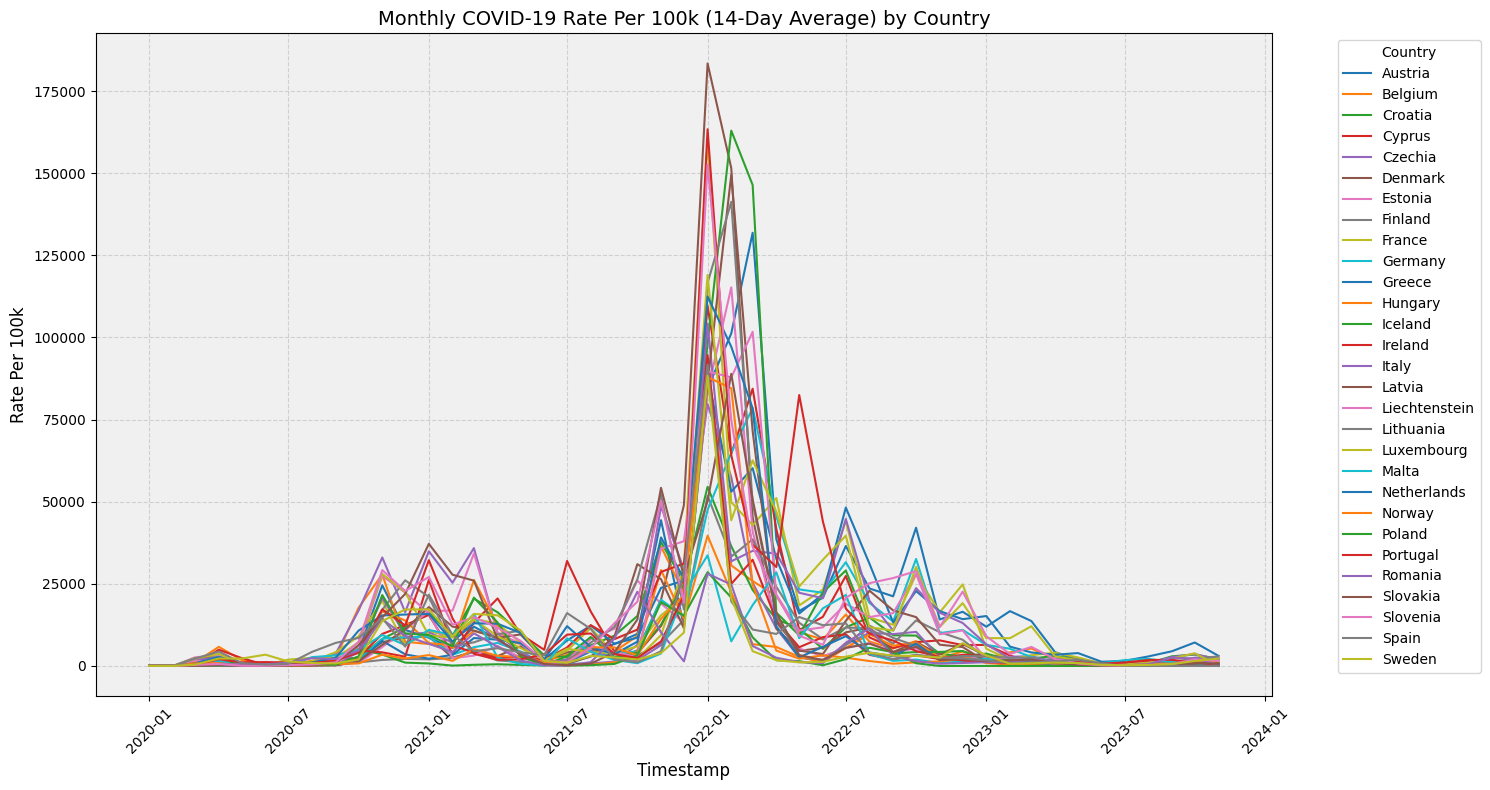

In [29]:
# Free up memory and close all figures
plt.close('all')

plt.figure(figsize=(15, 8))

# Plot each country's line
for country in df_covid_rate_country.columns:
    plt.plot(df_covid_rate_country.index, df_covid_rate_country[country], label=country)

plt.title('Monthly COVID-19 Rate Per 100k (14-Day Average) by Country', fontsize=14)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Rate Per 100k', fontsize=12)
plt.xticks(rotation=45)  
plt.grid(True, linestyle='--', alpha=0.5)  
plt.gca().set_facecolor('#f0f0f0')  
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')  

# Show plot
plt.tight_layout()  
plt.show()

This plot above illustrates the monthly COVID-19 rate per 100,000 inhabitants across various countries. The first notable peak occurs during the initial lockdowns in mid-2020 and early 2021, coinciding with the widespread implementation of strict public health measures. These peaks likely reflect the limited immunity in populations prior to the widespread availability of vaccines. [World Data](https://ourworldindata.org/covid-cases)

Following the relaxation of restrictions, the graph shows a subsequent surge in case rates, particularly in late 2021 and early 2022. This trend aligns with the emergence of more transmissible variants, such as Delta and Omicron, and the lifting of social distancing measures. However, the overall rates stabilize over time, likely due to increased vaccine coverage and natural immunity from prior infections. The reduction in case rates in late 2022 and 2023 also suggests improved public health management, including booster campaigns and effective treatments. (Tartof SY et al., 2024) Estimated Effectiveness of the BNT162b2 XBB Vaccine Against COVID-19. [link](https://jamanetwork.com/journals/jamainternalmedicine/fullarticle/2820268)

This plot provides a clear temporal view of how the pandemic evolved, highlighting the impact of interventions like lockdowns and vaccinations on transmission rates.

We are interested in evaluating how much these numbers would influence the forecasting accuracy. As multiple disruptions occurred in the supply chain due to the covid lockdowns and restrictions. For example an increased volatility as researched by [Capgemini](https://www.capgemini.com/wp-content/uploads/2020/11/Fast-forward_Report.pdf).

### Model Type

For this analysis I will use the following models. These can be clustered in four categories. 

- Statistical Models
- Machine Learning Models
- Deep Learning Models
- LLM Foundational Timeseries Models

#### Statistical Models 

- **ARIMA**:(AutoRegressive Integrated Moving Average) is a forecasting method that combines autoregression, differencing, and moving averages to model and predict time series data based on its own past values and errors.
- **Exponential Smoothing Models**: The exponential smoothing forecasting model is a method that predicts future data points by weighting past observations, giving more importance to recent data while gradually reducing the influence of older data
- **WindowAverage**: The WindowAverage model forecasts future values by calculating the average of the most recent observations within a defined window of time, smoothing out short-term fluctuations.

The python package ecosystem `nixtla` contains multiple package for different timeseries tasks. The package [statsforecast](https://nixtlaverse.nixtla.io/#statsforecast), is optimized for applying automated versions of these models. 

#### Machine Learning Models 

- **LightGBM** is a gradient boosting framework that uses tree-based learning algorithms to produce fast, efficient, and accurate predictions, particularly suited for large datasets and high-dimensional data [link](https://lightgbm.readthedocs.io/en/latest/index.html).
- **CatBoost** is a gradient boosting algorithm optimized for categorical features, designed to improve model accuracy and reduce overfitting on datasets with categorical variables. It uses ordered boosting and innovative feature handling techniques, making it particularly fast, robust, and suitable for a wide range of machine learning tasks, especially when handling complex, categorical data [link](https://catboost.ai/).

#### Deep Learning Models 

- **N-BEATS** (Neural Basis Expansion Analysis Time Series) is a deep learning model specifically designed for time series forecasting, focusing on trend and seasonality extraction through basis expansion.
  
- **N-HiTS** (Neural Hierarchical Interpolation for Time Series) is a neural model that improves hierarchical time series prediction accuracy by generating fine-grained interpolations.

- **TFT** (Temporal Fusion Transformer) is a model designed for interpretable, multivariate time series forecasting that combines temporal and static variables, using attention mechanisms to adaptively focus on relevant time points. 

- **KAN (Kolmogorov-Arnold Network)**: A time series forecasting model based on the Kolmogorov-Arnold representation theorem, using spline-based functions to capture both temporal and cross-variable dependencies, offering interpretability and computational efficiency for both univariate and multivariate series.

- **TFT** (Temporal Fusion Transformer) is a model designed for interpretable, multivariate time series forecasting that combines temporal and static variables, using attention mechanisms to adaptively focus on relevant time points.

- **TCN (Temporal Convolutional Network)**: A neural network model for sequence modeling and time series forecasting that uses causal convolutions and dilated convolutions. TCNs maintain a sequence order and can capture long-term dependencies by using receptive fields that grow exponentially, which makes them highly effective for various time-dependent tasks.

For this aim I will use the package `NeuralForecast`. This offers a large collection of neural forecasting models focused on their usability, and robustness. The models range from classic networks like MLP, RNNs to novel proven contributions like NBEATS, NHITS, TFT and other architectures. [link](https://nixtlaverse.nixtla.io/neuralforecast/docs/getting-started/introduction.html)

#### LLM Foundational Timeseries Models

- **Chronos**: From Amazon. Chronos is a family of pretrained time series forecasting models based on language model architectures. A time series is transformed into a sequence of tokens via scaling and quantization, and a language model is trained on these tokens using the cross-entropy loss. Once trained, probabilistic forecasts are obtained by sampling multiple future trajectories given the historical context. Chronos models have been trained on a large corpus of publicly available time series data, as well as synthetic data generated using Gaussian processes. [link](https://huggingface.co/amazon/chronos-t5-large)

- **Moirai**: From Salesforece. Moirai, the Masked Encoder-based Universal Time Series Forecasting Transformer is a Large Time Series Model pre-trained on LOTSA data.Given a time series, Moirai (prediction model) use the context window as input and outputs a prediction window. So, the user need to set the context_length and prediction_length in advance. For time series data, the information contained within a single timestamp is not rich enough. Therefore, we refer to consecutive time points as 'patches', forming the basic units of Moirai input (similar to the concept of word token in Language Models). Moirai provides various patch_size [8, 16, 32, 64, 128]. [link](https://huggingface.co/Salesforce/moirai-1.0-R-base)



## Data dictionary

*Create a data dictionary for all the variables in your data set. You may fill out the data description table or create your own table with Pandas:*

<br>


| Name  |   Description	| Role   	| Type   	|  Format 	|
|---	|---	        |---    	|---	    |---	|
|   x	|   	 X       |   	X    |   X	    |   X	|
|   	|   	        |   	    |   	    |   	|
|   	|   	        |   	    |   	    |   	|


<br>

- `Role`: response, predictor, ID (ID columns are not used in a model but can help to better understand the data)

- `Type`: nominal, ordinal or numeric

- `Format`: int, float, string, category, date or object

### Historical Transportation Volume Data

In [30]:
df_vol.columns = df_vol.columns.str.replace(" ", "_")
df_vol['Provider'] = df_vol['Provider'].astype('category')
df_vol['Plant'] = df_vol['Plant'].astype('category')
df_vol['ts_key'] = df_vol['ts_key'].astype('category')

# Store to Bronze Layer
df_vol.to_parquet("../data/raw/bronze/historical_volume_bronze.parquet")

In [31]:
df_vol.head()

,Timestamp,Provider,Plant,Actual_Vol_[Kg],Expected_Vol_[Kg],Year,Month,ts_key,Actual_Vol_[Tons],Expected_Vol_[Tons]
0,2015-07-01,Provider_1,Plant_1,19096.0,20298.0,2015,7,Provider_1-Plant_1,19.096,20.298
1,2015-08-01,Provider_1,Plant_1,187139.0,189973.0,2015,8,Provider_1-Plant_1,187.139,189.973
2,2015-09-01,Provider_1,Plant_1,181149.0,187798.0,2015,9,Provider_1-Plant_1,181.149,187.798
3,2015-10-01,Provider_1,Plant_1,202677.0,202327.0,2015,10,Provider_1-Plant_1,202.677,202.327
4,2015-11-01,Provider_1,Plant_1,272902.0,271765.0,2015,11,Provider_1-Plant_1,272.902,271.765


In [32]:
df_vol.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47058 entries, 0 to 60518
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Timestamp            47058 non-null  datetime64[ns]
 1   Provider             47058 non-null  category      
 2   Plant                47058 non-null  category      
 3   Actual_Vol_[Kg]      47055 non-null  float64       
 4   Expected_Vol_[Kg]    46951 non-null  float64       
 5   Year                 47058 non-null  int64         
 6   Month                47058 non-null  int64         
 7   ts_key               47058 non-null  category      
 8   Actual_Vol_[Tons]    47055 non-null  float64       
 9   Expected_Vol_[Tons]  46951 non-null  float64       
dtypes: category(3), datetime64[ns](1), float64(4), int64(2)
memory usage: 3.1 MB


In [33]:
data_dict_vol = pd.DataFrame({'Name': df_vol.columns, 
                              'Description':['Monthly date of the format YYYY-MM-DD', 
                                             'Logistics Provider ID',
                                             'Assembly Plant ID',
                                             'Actual transported volume from Provider to Plant in kg', 
                                             'Expected transported volume from Provider to Plant in kg', 
                                             'Year in which transport took place', 
                                             'Month in which transport took place',
                                             'Timeseries key', 
                                             'Actual transported volume from Provider to Plant in tons',
                                             'Expected transported volume from Provider to Plant in tons'], 
                              'Role':['ID', 'ID', 'ID', 'response', 'predictor','predictor', 'predictor','ID','predictor','predictor'], 
                              'Type':['ordinal','nominal','nominal', 'numeric','numeric','numeric','numeric','numeric','numeric','numeric'], 
                              'Format':['datetime','category','category','float','float','int','int','category','float','float']
                              })

In [34]:
data_dict_vol

,Name,Description,Role,Type,Format
0,Timestamp,Monthly date of the format YYYY-MM-DD,ID,ordinal,datetime
1,Provider,Logistics Provider ID,ID,nominal,category
2,Plant,Assembly Plant ID,ID,nominal,category
3,Actual_Vol_[Kg],Actual transported volume from Provider to Pla...,response,numeric,float
4,Expected_Vol_[Kg],Expected transported volume from Provider to P...,predictor,numeric,float
5,Year,Year in which transport took place,predictor,numeric,int
6,Month,Month in which transport took place,predictor,numeric,int
7,ts_key,Timeseries key,ID,numeric,category
8,Actual_Vol_[Tons],Actual transported volume from Provider to Pla...,predictor,numeric,float
9,Expected_Vol_[Tons],Expected transported volume from Provider to P...,predictor,numeric,float


### Production Data

In [35]:
df_prod['Plant'] = df_prod['Plant'].astype('category')

# Store to Bronze Layer
df_prod.to_parquet("../data/raw/bronze/production_plannig.parquet")

In [36]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Timestamp   2160 non-null   datetime64[ns]
 1   Plant       2160 non-null   category      
 2   Production  2160 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 36.7 KB


In [37]:
df_prod.head()

,Timestamp,Plant,Production
0,2014-01-01,Plant_6,11848
1,2014-02-01,Plant_6,13528
2,2014-03-01,Plant_6,12753
3,2014-04-01,Plant_6,12681
4,2014-05-01,Plant_6,13272


In [38]:
data_dict_prod = pd.DataFrame({'Name': df_prod.columns, 
                              'Description':['Monthly date of the format YYYY-MM-DD', 
                                             'Assembly Plant ID',
                                             'Production Volume in Number of Units', ], 
                              'Role':['ID', 'ID','predictor'], 
                              'Type':['ordinal','nominal', 'numeric'], 
                              'Format':['datetime','category','int']
                              })
data_dict_prod

,Name,Description,Role,Type,Format
0,Timestamp,Monthly date of the format YYYY-MM-DD,ID,ordinal,datetime
1,Plant,Assembly Plant ID,ID,nominal,category
2,Production,Production Volume in Number of Units,predictor,numeric,int


### Covid Data

In [39]:
df_covid_rate_country.head()

country,Austria,Belgium,Croatia,Cyprus,Czechia,Denmark,Estonia,Finland,France,Germany,...,Malta,Netherlands,Norway,Poland,Portugal,Romania,Slovakia,Slovenia,Spain,Sweden
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,7.349560,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012470,0.000000
2020-02-01,0.000000,0.128581,0.000000,0.000000,0.000000,10.772483,0.000000,0.000000,0.126875,0.317860,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.163893,0.000000
2020-03-01,815.846412,1125.853421,86.862664,461.356534,210.330163,431.378513,2638.263736,214.033822,155.408050,579.167334,...,272.170607,821.745882,776.503737,40.809999,382.391478,64.024297,49.277440,342.634445,2243.718334,410.371205
2020-04-01,1191.215264,5806.542811,507.298131,553.246805,636.363283,1321.943712,3238.057549,745.077849,0.000000,1537.853319,...,672.108340,2728.366246,830.019137,282.322208,2053.256600,528.470089,237.915352,584.068131,4390.540369,2263.530068
2020-05-01,169.398031,1764.826806,126.748422,128.259373,196.328309,605.683905,224.223921,425.947870,90.929635,400.929241,...,287.034566,859.865652,185.986751,262.907448,1088.189403,454.060351,46.803896,72.478708,884.223514,2255.439506


In [40]:
df_covid_rate_country = df_covid_rate_country.reset_index()
df_covid_rate_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Timestamp      47 non-null     datetime64[ns]
 1   Austria        47 non-null     float64       
 2   Belgium        47 non-null     float64       
 3   Croatia        47 non-null     float64       
 4   Cyprus         47 non-null     float64       
 5   Czechia        47 non-null     float64       
 6   Denmark        47 non-null     float64       
 7   Estonia        47 non-null     float64       
 8   Finland        47 non-null     float64       
 9   France         47 non-null     float64       
 10  Germany        47 non-null     float64       
 11  Greece         47 non-null     float64       
 12  Hungary        47 non-null     float64       
 13  Iceland        47 non-null     float64       
 14  Ireland        47 non-null     float64       
 15  Italy          47 non-nul

In [41]:
# Store to Bronze Layer
df_covid_rate_country.to_parquet("../data/raw/bronze/monthly_covid_rate_per_country.parquet")

In [42]:
data_dict_covid = pd.DataFrame({'Name': ['Timestamp', 'Country'], 
                              'Description':['Monthly date of the format YYYY-MM-DD', 
                                             'Monthly COVID-19 Rate Per 100k (14-Day Average) in the given country'], 
                              'Role':['ID','predictor'], 
                              'Type':['ordinal','numeric'], 
                              'Format':['datetime', 'float']
                              })
data_dict_covid

,Name,Description,Role,Type,Format
0,Timestamp,Monthly date of the format YYYY-MM-DD,ID,ordinal,datetime
1,Country,Monthly COVID-19 Rate Per 100k (14-Day Average...,predictor,numeric,float


In [43]:
print("Available countries ", df_covid_rate_country.columns[1:])

Available countries  Index(['Austria', 'Belgium', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
       'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary',
       'Iceland', 'Ireland', 'Italy', 'Latvia', 'Liechtenstein', 'Lithuania',
       'Luxembourg', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal',
       'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden'],
      dtype='object', name='country')
